### Price optimization
---

In short, this little problem stems from the one stated [here](https://www.analyticsvidhya.com/blog/2016/07/solving-case-study-optimize-products-price-online-vendor-level-hard), in which we are in charge of comming up with an optimal price for each item in a list that maximizes revenue.

Note that the real **challenge** in this kind of problems is to find/establish the price elasticity curve and to define the search space restrictions. In the given data, such relation and information is already given hence the problem can be approached from a mathematical optimization point of view: simplex, linear programming, etc...

This script solves the pricing list optimization using `deap` toolbox, a evolutionary programming framework in python.

Let's see how it behaves.

In [28]:
from deap import creator, base, tools, algorithms
import pandas as pd
import numpy as np
import random
import sys

In [29]:
#load data
dummy_data = "https://www.analyticsvidhya.com/wp-content/uploads/2016/07/Vendor_Data.csv"
data = pd.read_csv(dummy_data)

In [30]:
# Define evaluation function: maximize revenue. Should return a tuple for the sake of DEAP compatibility
def evalFitness(increment):
    price = data['Avg_Price_per_unit'] * (1 + increment)  # price variation
    volumes = data['Average_units_sold']*(1 - (data['Increase_sale_volume'] * increment * 10)) # volume sale variation
    multiplier = (1-(data['Incremental_acquisition']*increment*10)) # increase in customer response rate
    profit_wo_multiplier = 0.05*(price*volumes - volumes*data['Cost_per_unit']) # profit wo taking into account user response
    profit_w_multiplier = profit_wo_multiplier*multiplier  # profit taking into account user response
    net_profit = profit_w_multiplier.sum()
    return net_profit,

In [31]:
# Checks if an indivifual (an array of price modifications) is within the problem restrictions
def checkBounds(min, max):
    def decorator(func):
        def wrappper(*args, **kargs):
            offspring = func(*args, **kargs)
            for child in offspring:
                for i in range(len(child)):
                    if child[i] > max:
                        child[i] = max
                    elif child[i] < min:
                        child[i] = min
            return offspring
        return wrappper
    return decorator

In [32]:
# create the fitness function and the individual.

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", np.ndarray, fitness=creator.FitnessMax)

# register in the toolbox DEAP tools needed to initialize the problem and the algorithm evaluation
toolbox = base.Toolbox()

# initializes population individuals using a random uniform sample between the problem restrictions
toolbox.register("delta_incr", random.uniform, -0.099, 0.19)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.delta_incr, n=250)
toolbox.register("population", tools.initRepeat, list, toolbox.individual, n=100)

# register evaluation function
toolbox.register("evaluate", evalFitness)

# register crossover evaluation
toolbox.register("mate", tools.cxTwoPoint)

# register mutation policy
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.03, indpb=0.1)

# register the selection process 
toolbox.register("select",  tools.selTournament, tournsize=10)

# decorate the mate and mutate steps to be within the boundaries

toolbox.decorate("mate", checkBounds(-0.099, 0.19))
toolbox.decorate("mutate", checkBounds(-0.099, 0.19)) 

pop = toolbox.population(n=100)

hof = tools.HallOfFame(1, similar=np.array_equal)

stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("max", np.max)
stats.register("min", np.min)
stats.register("avg", np.mean)

In [33]:
%%time
result, log = algorithms.eaSimple(pop, toolbox,
                                  cxpb=0.1, mutpb=0.1,
                                  ngen=1000, verbose=False, halloffame=hof, stats=stats)


CPU times: user 18.6 s, sys: 12 ms, total: 18.6 s
Wall time: 18.5 s


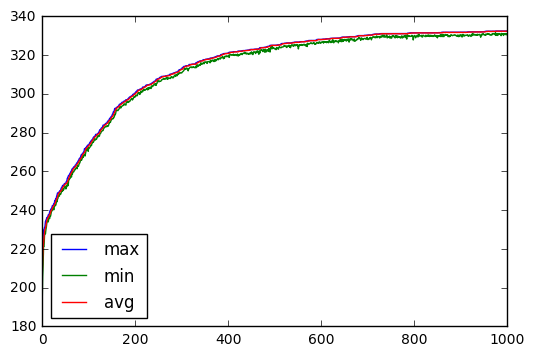

In [34]:
%matplotlib inline
import matplotlib.pyplot as plt

gen = [l['gen'] for l in log]

max_profit = [l['max'] for l in log]
min_profit = [l['min'] for l in log]
avg_profit = [l['avg'] for l in log]

plt.plot(gen, max_profit, label='max')
plt.plot(gen, min_profit, label='min')
plt.plot(gen, avg_profit, label='avg')

plt.legend(loc='best')

In [36]:
max(max_profit)

332.46874259298335

---

We see that after ~400 generations we reach to a *plateau* and the gain in revenue is marginal, indicating that we may have reached an optimal price for each item in the list.